### Homework 3:  Streamlit Application

Purpose: 

For this assignment, I have updated the model in Homework II from Decision Treen to Gradient Booster regression, and created a Streamlit app for easy visualization

**1. Data import & basic exploration**


In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import plotly.express as px
import plotly.offline as off
pd.options.plotting.backend = "plotly"
off.init_notebook_mode()
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df = pd.read_csv('../Unit2/data/bikeshare.csv', parse_dates = ['datetime'])

In [3]:
#Examine dataset structure
df.head()

datetime  season  holiday  workingday      weather  temp   atemp  \
0 2011-01-01 00:00:00  Spring        0           0  Clear Skies  9.84  14.395   
1 2011-01-01 01:00:00  Spring        0           0  Clear Skies  9.02  13.635   
2 2011-01-01 02:00:00  Spring        0           0  Clear Skies  9.02  13.635   
3 2011-01-01 03:00:00  Spring        0           0  Clear Skies  9.84  14.395   
4 2011-01-01 04:00:00  Spring        0           0  Clear Skies  9.84  14.395   

   humidity  windspeed  count  
0        81        0.0     16  
1        80        0.0     40  
2        80        0.0     32  
3        75        0.0     13  
4        75        0.0      1

In [4]:
df.tail()

datetime  season  holiday  workingday      weather   temp  \
10881 2012-12-19 19:00:00  Winter        0           1  Clear Skies  15.58   
10882 2012-12-19 20:00:00  Winter        0           1  Clear Skies  14.76   
10883 2012-12-19 21:00:00  Winter        0           1  Clear Skies  13.94   
10884 2012-12-19 22:00:00  Winter        0           1  Clear Skies  13.94   
10885 2012-12-19 23:00:00  Winter        0           1  Clear Skies  13.12   

        atemp  humidity  windspeed  count  
10881  19.695        50    26.0027    336  
10882  17.425        57    15.0013    241  
10883  15.910        61    15.0013    168  
10884  17.425        61     6.0032    129  
10885  16.665        66     8.9981     88

In [5]:
#check for datatype and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  object        
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  object        
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 850.6+ KB


In [6]:
#check for total no. of columns
df.shape

(10886, 10)

In [7]:
#check for any duplicated entries
df.duplicated().sum()

0

In [8]:
#check for any null values
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64

In [9]:
#basic descriptions of existing parameters
df.describe()

holiday    workingday         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.028569      0.680875     20.23086     23.655084     61.886460   
std        0.166599      0.466159      7.79159      8.474601     19.245033   
min        0.000000      0.000000      0.82000      0.760000      0.000000   
25%        0.000000      0.000000     13.94000     16.665000     47.000000   
50%        0.000000      1.000000     20.50000     24.240000     62.000000   
75%        0.000000      1.000000     26.24000     31.060000     77.000000   
max        1.000000      1.000000     41.00000     45.455000    100.000000   

          windspeed         count  
count  10886.000000  10886.000000  
mean      12.799395    191.574132  
std        8.164537    181.144454  
min        0.000000      1.000000  
25%        7.001500     42.000000  
50%       12.998000    145.000000  
75%       16.997900    284.000000  
max       56.996900    977.000000

In [10]:
#extract time information from datetime
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['dayofweek'] = df['datetime'].dt.dayofweek

In [11]:
#initial view of strong correlations: hour, temp and atemp most positively correlated, while humidity negatively correlates with count
df.corr(method='spearman')[['count']].sort_values(by = 'count')

count
humidity   -0.354049
holiday    -0.001634
workingday -0.000386
dayofweek   0.013497
windspeed   0.135777
month       0.180226
atemp       0.406562
temp        0.407989
hour        0.515495
count       1.000000

In [12]:
#note that counts distribution skews left 
df['count'].plot(kind = 'histogram', nbins = 20)

In [13]:
#Looking at some categorical data that was not included for correlation
#doesn't seem to have a significantly difference on avg. count weather it is a holiday or not
df.groupby('holiday')['count'].mean().plot(kind = 'bar', title = 'Count by holiday')

In [14]:
#there are some difference by season - Fall seems to be the most popular time for bikeshares, followed by summer
df.groupby('season')['count'].mean().plot(kind = 'bar', title = 'Count by season')

In [15]:
df.groupby('weather')['count'].mean().plot(kind = 'bar', title = 'Count by weather')

In [16]:
df.corr(method = 'spearman')
#note that temp & atemp are highly correlated, later on we may need to dimensionalize it

holiday  workingday      temp     atemp  humidity  windspeed  \
holiday     1.000000   -0.250491  0.001751 -0.003464  0.000186   0.009087   
workingday -0.250491    1.000000  0.031065  0.027566 -0.010048   0.017455   
temp        0.001751    0.031065  1.000000  0.987128 -0.046854  -0.005535   
atemp      -0.003464    0.027566  0.987128  1.000000 -0.042028  -0.036350   
humidity    0.000186   -0.010048 -0.046854 -0.042028  1.000000  -0.324447   
windspeed   0.009087    0.017455 -0.005535 -0.036350 -0.324447   1.000000   
count      -0.001634   -0.000386  0.407989  0.406562 -0.354049   0.135777   
hour       -0.000355    0.002777  0.140206  0.138817 -0.282403   0.151106   
month       0.001916   -0.003481  0.247465  0.246033  0.201920  -0.134769   
dayofweek  -0.191587   -0.705411 -0.040725 -0.044801 -0.025981  -0.023399   

               count      hour     month  dayofweek  
holiday    -0.001634 -0.000355  0.001916  -0.191587  
workingday -0.000386  0.002777 -0.003481  -0.705411  
temp        0.407989  0.140206  0.247465  -0.040725  
atemp       0.406562  0.138817  0.246033  -0.044801  
humidity   -0.354049 -0.282403  0.201920  -0.025981  
windspeed   0.135777  0.151106 -0.134769  -0.023399  
count       1.000000  0.515495  0.180226   0.013497  
hour        0.515495  1.000000 -0.006800  -0.002916  
month       0.180226 -0.006800  1.000000  -0.002265  
dayofweek   0.013497 -0.002916 -0.002265   1.000000

**2. Data transformation, encoding and initial model set up**

In [17]:
df['weather'].unique()

array(['Clear Skies', 'Partly Cloudy', 'Light Storms/Rain',
       'Heavy Storms/Rain'], dtype=object)

In [18]:
df['season'].unique()

array(['Spring', 'Summer', 'Fall', 'Winter'], dtype=object)

In [19]:
df = df.sort_values(by = 'datetime')
df.head()

datetime  season  holiday  workingday      weather  temp   atemp  \
0 2011-01-01 00:00:00  Spring        0           0  Clear Skies  9.84  14.395   
1 2011-01-01 01:00:00  Spring        0           0  Clear Skies  9.02  13.635   
2 2011-01-01 02:00:00  Spring        0           0  Clear Skies  9.02  13.635   
3 2011-01-01 03:00:00  Spring        0           0  Clear Skies  9.84  14.395   
4 2011-01-01 04:00:00  Spring        0           0  Clear Skies  9.84  14.395   

   humidity  windspeed  count  hour  month  dayofweek  
0        81        0.0     16     0      1          5  
1        80        0.0     40     1      1          5  
2        80        0.0     32     2      1          5  
3        75        0.0     13     3      1          5  
4        75        0.0      1     4      1          5

In [20]:
#build pipeline
pipe1 = make_pipeline(ce.OrdinalEncoder(), GradientBoostingRegressor(max_depth = 3))
pipe2 = make_pipeline(ce.OneHotEncoder(use_cat_names = True), GradientBoostingRegressor(max_depth = 3))
pipe3 = make_pipeline(ce.TargetEncoder(), GradientBoostingRegressor(max_depth = 3))

In [21]:
X = df.drop(['datetime','count'], axis = 1)
y = df['count']

In [22]:
#identify the last 20% of dataset as testing. because time is involved, will keep it chronological for training / val / test split
-10886*0.2

-2177.2000000000003

In [23]:
(10886-2178)*0.15

1306.2

In [24]:
10886-2178-1306

7402

In [25]:
def get_val_scores(X,y, estimator):
    X_train = X[:-2178]
    X_test = X[-2178:]
    y_train = y[:-2178]
    y_test = y[-2178:]
    X_train = X[:-1306]
    X_val = X[-1306:]
    y_train = y[:-1306]
    y_val = y[-1306:]
    estimator.fit(X_train, y_train)
    
    return estimator.score(X_val, y_val)

In [26]:
ordinal_score = get_val_scores(X,y, pipe1)
onehot_score = get_val_scores(X,y, pipe2)
target_score = get_val_scores(X,y, pipe3)

In [27]:
print(ordinal_score, onehot_score, target_score)

0.5860290218827484 0.5802952655166254 0.582061394031909


From above, we see val set and test set render similar results. Given there are multiple values that could go into weather, season etc, we will focus on target encoding. The low score also indicates we may need to dig up more variables to account for changes in y to increase predictability

In [28]:
pd.DataFrame({
    'col': X.columns,
    'imp': pipe3[-1].feature_importances_
}).sort_values(by = 'imp', ascending = False)

#hour & temp has the most significant impact on bikeshare amounts.

col       imp
8         hour  0.648195
4         temp  0.113520
2   workingday  0.089033
5        atemp  0.088566
6     humidity  0.026510
10   dayofweek  0.011160
3      weather  0.010152
9        month  0.006907
0       season  0.002632
7    windspeed  0.002609
1      holiday  0.000717

**3. Model Adjustment / Refinement**

a. Search for additional calculated variables that may help with prediction

In [29]:
#would like to look at prediction power looking at previous 8 hours of performance - dividing each day into 3 sections
#also look at same time previous day for prediction

In [30]:
df['8h'] = df['count'].rolling(8).mean().shift().values
df['24h'] = df['count'].rolling(24).mean().shift().values
df = df.bfill()

In [31]:
df.head()

datetime  season  holiday  workingday      weather  temp   atemp  \
0 2011-01-01 00:00:00  Spring        0           0  Clear Skies  9.84  14.395   
1 2011-01-01 01:00:00  Spring        0           0  Clear Skies  9.02  13.635   
2 2011-01-01 02:00:00  Spring        0           0  Clear Skies  9.02  13.635   
3 2011-01-01 03:00:00  Spring        0           0  Clear Skies  9.84  14.395   
4 2011-01-01 04:00:00  Spring        0           0  Clear Skies  9.84  14.395   

   humidity  windspeed  count  hour  month  dayofweek    8h        24h  
0        81        0.0     16     0      1          5  13.5  41.041667  
1        80        0.0     40     1      1          5  13.5  41.041667  
2        80        0.0     32     2      1          5  13.5  41.041667  
3        75        0.0     13     3      1          5  13.5  41.041667  
4        75        0.0      1     4      1          5  13.5  41.041667

In [32]:
X1 = df.drop(['datetime','count'], axis = 1)
y1 = df['count']

In [33]:
get_val_scores(X1,y1, pipe3)

#there is actually an improvement on fit score!

0.7817331928365904

In [34]:
pipe3[-1].feature_importances_

array([2.59222008e-04, 2.57447223e-04, 5.22193856e-02, 9.79523594e-03,
       9.48258507e-03, 4.47957216e-02, 7.42319120e-03, 5.15989067e-04,
       6.27137095e-01, 8.96569157e-04, 1.20373963e-02, 1.65827437e-02,
       2.18597418e-01])

In [35]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'hour', 'month', 'dayofweek',
       '8h', '24h'],
      dtype='object')

In [36]:
pd.DataFrame({
    'col': df.drop(['datetime','count'], axis = 1).columns,
    'imp': pipe3[-1].feature_importances_
}).sort_values(by = 'imp', ascending = False)

#hour is still the most important factor, but we can also derive significant information from data 24h hours ago (same time previous day), which would help with planning. 

col       imp
8         hour  0.627137
12         24h  0.218597
2   workingday  0.052219
5        atemp  0.044796
11          8h  0.016583
10   dayofweek  0.012037
3      weather  0.009795
4         temp  0.009483
6     humidity  0.007423
9        month  0.000897
7    windspeed  0.000516
0       season  0.000259
1      holiday  0.000257

b. Remembering there is an apparent left skew of the data, we also want to look at log values and see if that improves prediction

In [37]:
px.histogram(df['count'])

In [38]:
px.histogram(np.log(df['count']))

In [39]:
y2 = np.log(df['count'])

In [40]:
get_val_scores(X1,y2,pipe3)
#there is another major improvement!

0.9156926667330849

**4. Hyper-Parameter Tuning**

Then we also want to identify the best parameters for the model (based on model score)

In [41]:
max_depth = [3,4,5, 6]
max_features = [0.6, 0.8, 1]
learning_rate = [0.05, 0.1, 0.2]
n_estimators = [50, 100, 200, 300, 400]

In [42]:
cv_scores = []

In [43]:
for depth in max_depth:
    for feature in max_features:
        for rate in learning_rate:
            for estimator in n_estimators:
                print(f"Getting validation score for: depth: {depth}, max_features: {feature}, learning_rate: {rate}, n_estimators: {estimator}")
                pipe3[-1].set_params(max_depth = depth, max_features = feature, learning_rate = rate, n_estimators = estimator)
                val_score = get_val_scores(X1,y2, pipe3)
                cv_scores.append((val_score, depth, feature, rate, estimator))

Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.05, n_estimators: 50
Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.05, n_estimators: 100
Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.05, n_estimators: 200
Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.05, n_estimators: 300
Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.05, n_estimators: 400
Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.1, n_estimators: 50
Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.1, n_estimators: 100
Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.1, n_estimators: 200
Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.1, n_estimators: 300
Getting validation score for: depth: 3, max_features: 0.6, learning_rate: 0.1, n_estimators: 400
Getting validation score fo

Getting validation score for: depth: 4, max_features: 1, learning_rate: 0.2, n_estimators: 50
Getting validation score for: depth: 4, max_features: 1, learning_rate: 0.2, n_estimators: 100
Getting validation score for: depth: 4, max_features: 1, learning_rate: 0.2, n_estimators: 200
Getting validation score for: depth: 4, max_features: 1, learning_rate: 0.2, n_estimators: 300
Getting validation score for: depth: 4, max_features: 1, learning_rate: 0.2, n_estimators: 400
Getting validation score for: depth: 5, max_features: 0.6, learning_rate: 0.05, n_estimators: 50
Getting validation score for: depth: 5, max_features: 0.6, learning_rate: 0.05, n_estimators: 100
Getting validation score for: depth: 5, max_features: 0.6, learning_rate: 0.05, n_estimators: 200
Getting validation score for: depth: 5, max_features: 0.6, learning_rate: 0.05, n_estimators: 300
Getting validation score for: depth: 5, max_features: 0.6, learning_rate: 0.05, n_estimators: 400
Getting validation score for: depth: 

Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.1, n_estimators: 50
Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.1, n_estimators: 100
Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.1, n_estimators: 200
Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.1, n_estimators: 300
Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.1, n_estimators: 400
Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.2, n_estimators: 50
Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.2, n_estimators: 100
Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.2, n_estimators: 200
Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.2, n_estimators: 300
Getting validation score for: depth: 6, max_features: 1, learning_rate: 0.2, n_estimators: 400


In [44]:
max(cv_scores)

(0.9386800615944217, 5, 0.8, 0.05, 300)

In [45]:
pipe3[-1].set_params(max_depth = 6,max_features = 0.8,learning_rate = 0.1,n_estimators = 200)

#max_feature means randomly sampling 80% of data

GradientBoostingRegressor(max_depth=6, max_features=0.8, n_estimators=200)

In [46]:
get_val_scores(X1,y2,pipe3)


0.9222194150790952

In [47]:
def get_test(X,y, estimator):
    X_train = X[:-2178]
    X_test = X[-2178:]
    y_train = y[:-2178]
    y_test = y[-2178:]
    X_train = X[:-1306]
    X_val = X[-1306:]
    y_train = y[:-1306]
    y_val = y[-1306:]
    estimator.fit(X_train, y_train)
    
    return estimator.score(X_test, y_test)

In [48]:
get_test(X1,y2, pipe3)

#reasonably similar to validation set, indicating good general prediction capabilities of the model

0.9469819383991673

In [49]:
pd.DataFrame({
    'col': X1.columns,
    'imp': pipe3[-1].feature_importances_
}).sort_values(by = 'imp', ascending = False)

col       imp
8         hour  0.718559
12         24h  0.079738
2   workingday  0.052340
11          8h  0.043054
5        atemp  0.030980
10   dayofweek  0.028041
4         temp  0.018495
3      weather  0.008723
9        month  0.008265
6     humidity  0.006974
7    windspeed  0.002622
0       season  0.001421
1      holiday  0.000788

In [50]:
pipe3
#redefine the pipeline to only encode

Pipeline(steps=[('targetencoder', TargetEncoder(cols=['season', 'weather'])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=6, max_features=0.8,
                                           n_estimators=200))])

**5. Look at partical dependency**

How individual value impact the outcome

In [51]:
from pdpbox import pdp, info_plots

In [52]:
pipe3[0]

TargetEncoder(cols=['season', 'weather'])

In [53]:
X_train = X1[:-2178]
y_train = y2[:-2178]
te = ce.TargetEncoder()
X_train = te.fit_transform(X_train, y_train)
X_train.head()

season  holiday  workingday   weather  temp   atemp  humidity  windspeed  \
0  3.984206        0           0  4.544039  9.84  14.395        81        0.0   
1  3.984206        0           0  4.544039  9.02  13.635        80        0.0   
2  3.984206        0           0  4.544039  9.02  13.635        80        0.0   
3  3.984206        0           0  4.544039  9.84  14.395        75        0.0   
4  3.984206        0           0  4.544039  9.84  14.395        75        0.0   

   hour  month  dayofweek    8h        24h  
0     0      1          5  13.5  41.041667  
1     1      1          5  13.5  41.041667  
2     2      1          5  13.5  41.041667  
3     3      1          5  13.5  41.041667  
4     4      1          5  13.5  41.041667

In [54]:
X_col = X_train.columns

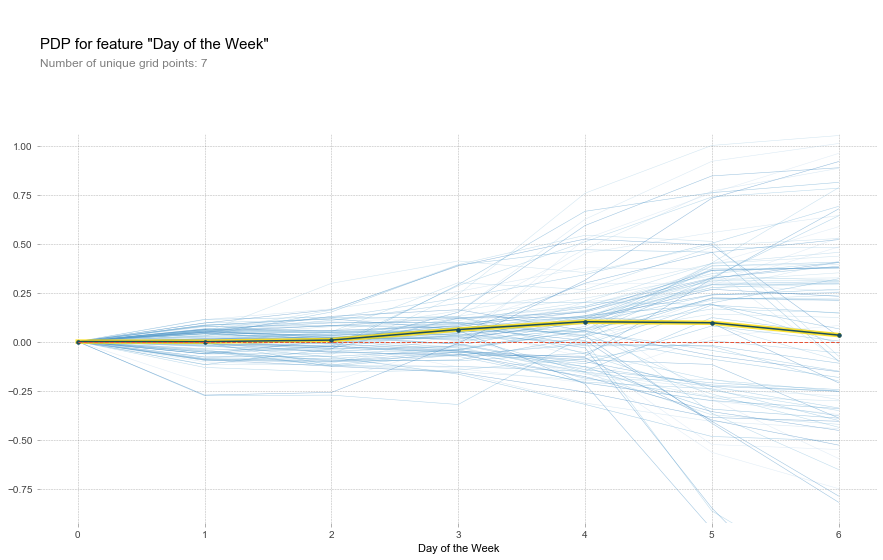

In [55]:
pdp_day_of_week = pdp.pdp_isolate(
    model=pipe3[-1], dataset=X_train, model_features=X_col.tolist(), 
    feature='dayofweek', cust_grid_points = X_train['dayofweek'].unique().tolist()
)

fig, axes = pdp.pdp_plot(pdp_day_of_week, 'Day of the Week', plot_lines=True, frac_to_plot=100)

#similar to what the model suggest, count is almost independent of day of week

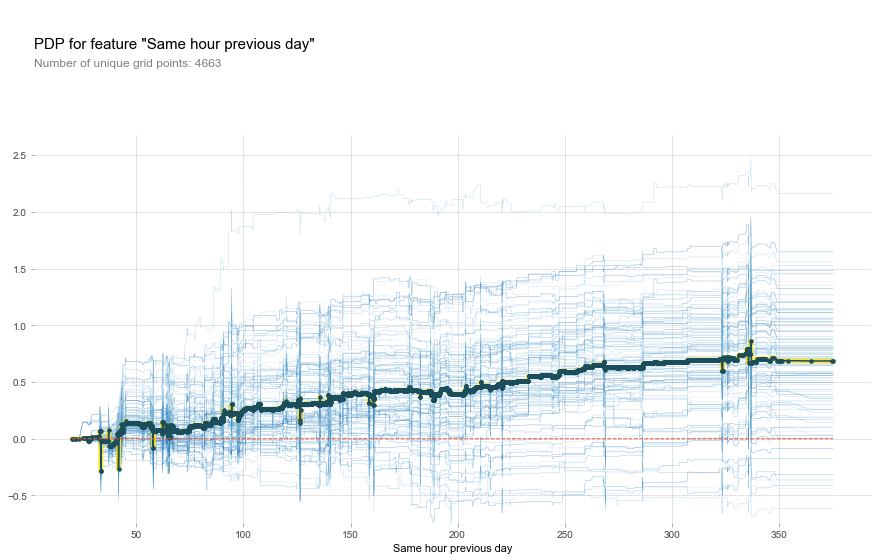

In [56]:
pdp_24h = pdp.pdp_isolate(
    model=pipe3[-1], dataset=X_train, model_features=X_train.columns.tolist(), 
    feature='24h', cust_grid_points = X_train['24h'].unique().tolist() 
)
fig, axes = pdp.pdp_plot(pdp_24h, 'Same hour previous day', plot_lines=True, frac_to_plot=100)
#we could see step change positive dependency on same hour previous day counts

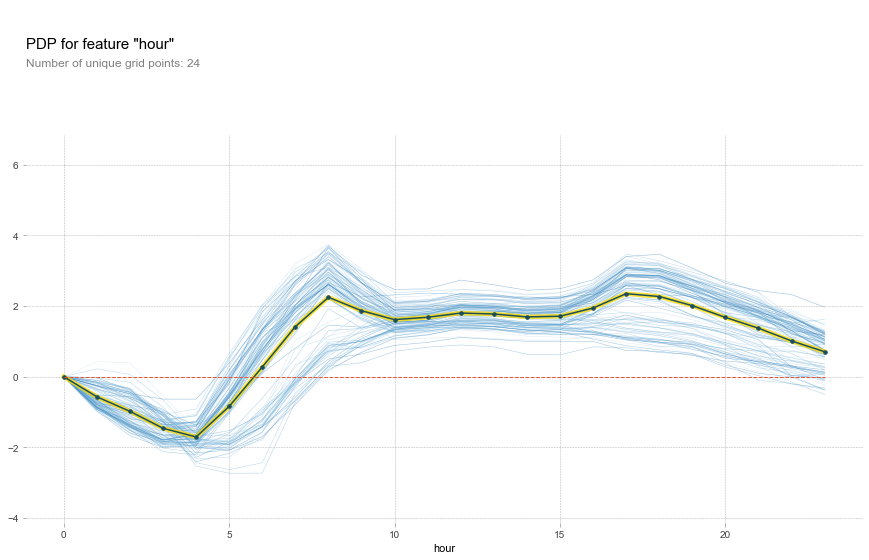

In [57]:
pdp_hour = pdp.pdp_isolate(
    model=pipe3[-1], dataset=X_train, model_features=X_train.columns.tolist(), 
    feature='hour', cust_grid_points = X_train['hour'].unique().tolist() 
)

fig, axes = pdp.pdp_plot(pdp_hour, 'hour', plot_lines=True, frac_to_plot=100)

**6. Simplify the model for application**

In [58]:
X = df[['hour', '24h', 'temp']]
y = df['count']

#for simplicity here I selected only key metrics  

In [59]:
booster = GradientBoostingRegressor(max_depth = 6,max_features = 0.8,learning_rate = 0.1,n_estimators = 200)

In [60]:
pipe_new = make_pipeline(ce.TargetEncoder(), booster)

In [61]:
pipe_new.fit(X,y)

Pipeline(steps=[('targetencoder', TargetEncoder(cols=[])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=6, max_features=0.8,
                                           n_estimators=200))])

**7. Export set up for visualization**

In [62]:
import pickle

with open('bikeshare.pkl', 'wb') as export:
    # this creates an external version of the file that we can now import later on
    pickle.dump(pipe_new, export)

In [63]:
with open('bikeshare.pkl', 'rb') as import_:
    # this will import the pickled object again
    pipe_new = pickle.load(import_)

In [64]:
pipe_new

Pipeline(steps=[('targetencoder', TargetEncoder(cols=[])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=6, max_features=0.8,
                                           n_estimators=200))])

In [75]:
pipe_new.predict(X)

array([ 15.55314021,  13.30110188,  11.2169515 , ..., 174.00910098,
       135.98922957, 101.5388005 ])